In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import shap

/home/light/research/plid/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and Target

In [19]:
# Load the data
df = pd.read_csv('plid.csv')

TARGET_COLUMNS = ['Post operative ODI',
    'Post operative NRS back pain',
    'Surgery outcome according to Macnab criteria',
    'Post operative NRS leg pain']

print(f"Original DataFrame shape: {df.shape}")

# %%

# Apply Listwise Deletion (LWD)
# FIX: Ensure subset uses a list [TARGET_COLUMNS[0]]
df_lwd = df.dropna(subset=[TARGET_COLUMNS[0]]).copy() 

# Define feature matrix X (drop all targets)
X = df_lwd.drop(columns=TARGET_COLUMNS) 
X.drop(columns=['Timestamp'], inplace=True, errors='ignore')  # Drop Timestamp if exists

# FIX: Define Y as the SINGLE target column for prediction
Y = df_lwd[TARGET_COLUMNS[0]] 

# Split the LWD data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# %%
print(f"Cleaned Feature Matrix X shape: {X.shape}")
print(f"Target Vector Y shape: {Y.shape}")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")


Original DataFrame shape: (349, 25)
Cleaned Feature Matrix X shape: (78, 20)
Target Vector Y shape: (78,)
X_train shape: (62, 20), Y_train shape: (62,)


In [33]:
print("--- Feature Verification ---")
print(f"Total features in X: {len(X.columns)}")
print(f"Features present in X that SHOULD NOT be targets: {set(TARGET_COLUMNS).intersection(X.columns)}")
print(f"Number of columns in X with ANY NaN values: {X.isna().any().sum()}") 


--- Feature Verification ---
Total features in X: 20
Features present in X that SHOULD NOT be targets: set()
Number of columns in X with ANY NaN values: 15


## Imputation Pipeline & Column Transfer

In [20]:
# 1. Define Feature Sets
MNAR_CATEGORICAL_FEATURES = ['Low back pain',
        'Low back pain with Sciatica', 'Bowel Bladder Involvement',
        'Straight Leg Raising Test', 'Femoral Stretching Test',
        'Sensory Involvement', 'Motor involvement', 'Knee Jerk', 'Ankle Jerk']
NUMERICAL_FEATURES = ['Pre operative ODI',
        'Pre operative NRS back pain',
        'Pre operative NRS leg pain']
# All remaining object columns are treated as Nominal Categorical
NOMINAL_CATEGORICAL_FEATURES = list(
    X.select_dtypes(include=['object']).columns.difference(MNAR_CATEGORICAL_FEATURES)
)
# Ensure any unlisted numerical columns are also handled as remainder='drop' 
# or included here. We will ensure all feature columns are accounted for:
# Let's add any remaining numerical columns (like 'Age' in the mock data) to NUMERICAL_FEATURES
numerical_cols_remaining = list(
    X.select_dtypes(include=np.number).columns.difference(NUMERICAL_FEATURES)
)
NUMERICAL_FEATURES.extend(numerical_cols_remaining)

print(f"Nominal Categorical Features: {NOMINAL_CATEGORICAL_FEATURES}")


Nominal Categorical Features: ['Age', 'Annulus', 'Level of Disc Prolapse', 'Occupation', 'Operative Findings', 'Sex', 'Type of Operation']


In [34]:
all_defined_features = set(MNAR_CATEGORICAL_FEATURES + NUMERICAL_FEATURES)

# NOTE: We need to recreate NOMINAL_CATEGORICAL_FEATURES exactly as you defined it
# to ensure it's accurate:
NOMINAL_CATEGORICAL_FEATURES = list(
    X.select_dtypes(include=['object']).columns.difference(MNAR_CATEGORICAL_FEATURES)
)
all_defined_features.update(NOMINAL_CATEGORICAL_FEATURES)


all_X_features = set(X.columns)

# 2. Find the difference: features present in X but not in any list
unaccounted_features = all_X_features.difference(all_defined_features)

print("--- Unaccounted Feature Identification ---")
print(f"Total features defined in pipelines: {len(all_defined_features)}")
print(f"Total features in X: {len(all_X_features)}")
print(f"\nFEATURES THAT WERE DROPPED:")
print(unaccounted_features)

print("\n--- Diagnostic Strategy ---")
if len(unaccounted_features) > 0:
    print("ACTION: You must assign these dropped features to one of your existing pipelines (likely 'numerical_pipeline' or 'nominal_pipeline').")
else:
    print("The issue is not feature dropping. Proceed to Imputation Bias Check (using simplified imputation).")


--- Unaccounted Feature Identification ---
Total features defined in pipelines: 20
Total features in X: 20

FEATURES THAT WERE DROPPED:
set()

--- Diagnostic Strategy ---
The issue is not feature dropping. Proceed to Imputation Bias Check (using simplified imputation).


In [27]:

# 2. Build Component Pipelines
# Pipeline for MNAR categorical data (Impute 'Unknown', then One Hot Encode)
# MNAR features are imputed with a constant 'Unknown' value to explicitly
# capture the missingness, treating it as its own category.
mnar_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipeline for Numerical data (Impute Median, then Scale)
# Numerical features are imputed with the median to be robust to outliers,
# and then scaled to have zero mean and unit variance.
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for Nominal categorical data (Impute Mode, then One Hot Encode)
# Nominal features are imputed with the mode (most frequent) and then One-Hot Encoded.
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

transformer_list = [
    ('mnar_cat_proc', mnar_pipeline, MNAR_CATEGORICAL_FEATURES),
    ('num_proc', numerical_pipeline, NUMERICAL_FEATURES),
    ('nom_cat_proc', nominal_pipeline, NOMINAL_CATEGORICAL_FEATURES)
]

# 3. Integrate components using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=transformer_list,
    # remainder='drop',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [38]:
# 1. Combine all categorical features
ALL_CATEGORICAL_FEATURES = MNAR_CATEGORICAL_FEATURES + NOMINAL_CATEGORICAL_FEATURES

# 2. Define Simplified Categorical Pipeline (Impute Mode, then One Hot Encode)
# We are replacing the MNAR strategy with simple mode imputation for all categorical data.
simplified_cat_pipeline = Pipeline(steps=[
    # Impute mode for ALL categorical features
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Build new transformer list
simplified_transformer_list = [
    ('cat_proc', simplified_cat_pipeline, ALL_CATEGORICAL_FEATURES),
    # Reuse the existing numerical pipeline
    ('num_proc', numerical_pipeline, NUMERICAL_FEATURES) 
]

# 4. Integrate components using ColumnTransformer
simple_preprocessor = ColumnTransformer(
    transformers=simplified_transformer_list,
    remainder='drop',
    verbose_feature_names_out=False
).set_output(transform="pandas")

# 5. Build the new pipeline (using Ridge for stability)
ridge_simple_pipeline = Pipeline(steps=[
    ('preprocessor', simple_preprocessor),
    ('regressor', Ridge(random_state=42))
])

print("Fitting Simplified Imputation Ridge Pipeline...")
ridge_simple_pipeline.fit(X_train, Y_train) # Ensure Y is single-column

# 6. Evaluate
Y_pred_simple = ridge_simple_pipeline.predict(X_test)
r2_simple = r2_score(Y_test, Y_pred_simple)

print(f"\n--- Simplified Imputation Test Result (Ridge) ---")
print(f"R-squared (R2): {r2_simple:.3f}")

Fitting Simplified Imputation Ridge Pipeline...

--- Simplified Imputation Test Result (Ridge) ---
R-squared (R2): -1.595


## ML pipeline

In [28]:
# Define the estimator (e.g., Random Forest)
rfr_estimator = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)

# Build the final end-to-end pipeline
rfr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rfr_estimator)
])

# Fit the pipeline to the training data
print("Fitting Random Forest Pipeline (Single-Target: 'Post operative ODI')...")
rfr_pipeline.fit(X_train, Y_train)
print("Pipeline fitted successfully.")

Fitting Random Forest Pipeline (Single-Target: 'Post operative ODI')...
Pipeline fitted successfully.


## Training, Prediction, Evaluation

In [29]:
# Make predictions
Y_pred = rfr_pipeline.predict(X_test)

# Calculate metrics (now applied to the single target vector Y_test)
r2 = r2_score(Y_test, Y_pred)
rmse = root_mean_squared_error(Y_test, Y_pred) # No need for squared=False if using function
mae = mean_absolute_error(Y_test, Y_pred)

print(f"--- Model Evaluation for 'Post operative ODI' ---")
print(f"R-squared (R2): {r2:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} (ODI Points)")
print(f"Mean Absolute Error (MAE): {mae:.2f} (ODI Points)")

# --- Interpretation Example: Permutation Importance ---
# Compute Permutation Importance on the test set
r_importances = permutation_importance(
    rfr_pipeline, X_test, Y_test, n_repeats=10, random_state=42, scoring='r2'
)

# Organize and display feature importance
# Get feature names from the preprocessor step
feature_names = rfr_pipeline['preprocessor'].get_feature_names_out() 
sorted_idx = r_importances.importances_mean.argsort()[::-1]

print("\nPermutation Feature Importance (Top 5):")
for i in sorted_idx[:5]:
    # FIX: Use the processed feature names for accurate labeling
    print(f"{feature_names[i]:<30}: {r_importances.importances_mean[i]:.4f}")


--- Model Evaluation for 'Post operative ODI' ---
R-squared (R2): -0.889
Root Mean Squared Error (RMSE): 16.25 (ODI Points)
Mean Absolute Error (MAE): 11.85 (ODI Points)

Permutation Feature Importance (Top 5):
Low back pain_Unknown         : 0.0684
Sensory Involvement_Unknown   : 0.0228
Low back pain with Sciatica_Left: 0.0090
Straight Leg Raising Test_Not Restricted: 0.0048
Low back pain with Sciatica_Both: 0.0026


In [32]:
# create linearRegression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=0.9))
])

lr_pipeline.fit(X_train, Y_train)
print("Linear Regression Pipeline fitted successfully.")

Y_pred_lr = lr_pipeline.predict(X_test)
print(f"--- Linear Regression Model Evaluation for 'Post operative ODI' ---")
r2_lr = r2_score(Y_test, Y_pred_lr)
rmse_lr = root_mean_squared_error(Y_test, Y_pred_lr)
mae_lr = mean_absolute_error(Y_test, Y_pred_lr)
print(f"R-squared (R2): {r2_lr:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f} (ODI Points)")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f} (ODI Points)")

Linear Regression Pipeline fitted successfully.
--- Linear Regression Model Evaluation for 'Post operative ODI' ---
R-squared (R2): -2.262
Root Mean Squared Error (RMSE): 21.35 (ODI Points)
Mean Absolute Error (MAE): 16.82 (ODI Points)


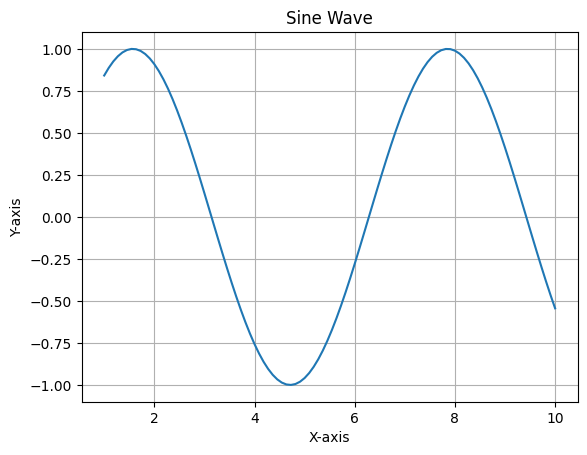

In [ ]:
import matplotlib.pyplot as plt

x = np.linspace(1,10,100)
y = np.sin(x)

plt.plot(x,y)
plt.title("Sine Wave")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid()
plt.savefig("sine_wave.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_129433/640410987.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(unique_labels["Param"])
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic 

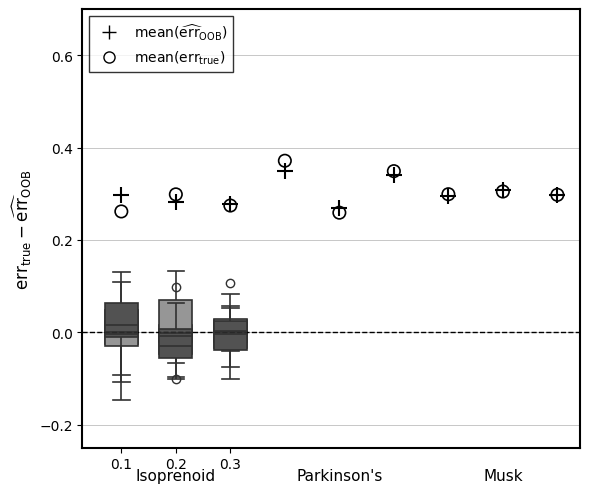

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. SETUP THE "ACADEMIC" STYLE ---
# This forces the text to look like LaTeX (Times New Roman-ish)
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.grid": True,
    "grid.color": "#b0b0b0", # Darker gray grid
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
    "axes.axisbelow": True, # Grid behind the plot
})

# --- 2. CREATE DUMMY DATA ---
# We simulate the structure: 3 datasets, 3 parameters (0.1, 0.2, 0.3)
datasets = ["Isoprenoid", "Parkinson's", "Musk"]
params = [0.1, 0.2, 0.3]
data = []

for ds in datasets:
    for p in params:
        # Generate 20 random points for the boxplot (simulating error difference)
        # Centered around 0 like in your image
        vals = np.random.normal(0, 0.05, 20)
        
        # Generate the "Mean" values for the top markers (+ and o)
        # These are usually absolute errors, so they are higher up (0.2 - 0.4)
        mean_oob = np.random.uniform(0.25, 0.35) 
        mean_true = mean_oob + np.random.normal(0, 0.02)
        
        for v in vals:
            data.append({
                "Dataset": ds, "Param": str(p), "Value": v, 
                "Type": "Box", "Mean_OOB": mean_oob, "Mean_True": mean_true
            })

df = pd.DataFrame(data)

# Create a combined column for the X-axis (e.g., "Isoprenoid\n0.1")
# This creates the grouping effect without complex multi-indexing
df["Label"] = df["Param"] 

# --- 3. PLOTTING ---
fig, ax = plt.subplots(figsize=(6, 5))

# A. The Boxplot (The gray boxes)
# We plot by 'Dataset' and 'Param' manually to control order
# Using a grayscale palette
sns.boxplot(data=df, x="Label", y="Value", hue="Dataset", 
            palette=["#d9d9d9", "#969696", "#525252"], # Grays
            linewidth=1.2, width=0.6, ax=ax, dodge=False)

# B. The Markers (The + and o symbols)
# We calculate the position for each distinct x-tick
unique_labels = df[["Dataset", "Param"]].drop_duplicates().reset_index(drop=True)
for i, row in unique_labels.iterrows():
    # Get the means for this group
    group_data = df[(df["Dataset"] == row["Dataset"]) & (df["Param"] == row["Param"])].iloc[0]
    
    # Plot 'mean(err_OOB)' as a Cross (+)
    ax.scatter(i, group_data["Mean_OOB"], marker='+', s=120, color='black', zorder=10, linewidth=1.5)
    
    # Plot 'mean(err_true)' as a Circle (o)
    ax.scatter(i, group_data["Mean_True"], marker='o', s=80, facecolors='none', edgecolors='black', zorder=10, linewidth=1.2)

# --- 4. FINE TUNING (The "Paper" Look) ---

# Formatting X-axis to look like the image (Two rows of labels)
# We hide the standard labels and draw custom text
ax.set_xticklabels(unique_labels["Param"])
ax.set_xlabel("") # Clear default label

# Add the Dataset names below the numbers (The "Group" labels)
# We place text manually at the center of each group (indices 1, 4, 7...)
group_centers = [1, 4, 7] # approximate centers for 3 groups of 3
for center, label in zip(group_centers, datasets):
    ax.text(center, -0.32, label, ha='center', fontsize=11)

# Add the dashed zero line
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Axis styling
ax.set_ylabel(r"$\text{err}_{\text{true}} - \widehat{\text{err}}_{\text{OOB}}$", fontsize=12)
ax.set_ylim(-0.25, 0.7) # Match the range in your image

# Custom Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='+', color='w', markeredgecolor='black', markersize=10, label=r'mean($\widehat{\text{err}}_{\text{OOB}}$)'),
    Line2D([0], [0], marker='o', color='w', markeredgecolor='black', markersize=8, label=r'mean($\text{err}_{\text{true}}$)')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True, edgecolor='black', fancybox=False)

# Add the thick border around the plot
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')

plt.tight_layout()
plt.show()